In [1]:
# 朴素贝叶斯模型
import warnings
warnings.filterwarnings('ignore')

import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as sm
import sklearn.model_selection as ms
import sklearn.naive_bayes as nb
import sklearn.feature_extraction.text as ft

# 加载文件
data = pd.read_csv("htl_all.csv")
data["label"].value_counts()

1    5322
0    2443
Name: label, dtype: int64

In [2]:
def func(item):
    # 分词
    seg_list = jieba.cut_for_search(item)
    return ' '.join(seg_list)


# print(data['discuss'])
data['new_review'] = data['review'].apply(func)
data.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\juemie\AppData\Local\Temp\jieba.cache
Loading model cost 0.539 seconds.
Prefix dict has been built successfully.


,label,review,new_review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较...","距离 川沙 公路 较近 , 但是 公交 指示 不 对 , 如果 是 "" 蔡陆线 "" 的话 ,..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!,商务 大床 房 ， 房间 很大 ， 床有 2M 宽 ， 整体 感觉 经济 实惠 不错 !
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。,早餐 太 差 ， 无论 去 多少 人 ， 那边 也 不加 食品 的 。 酒店 应该 重视 一...
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...,宾馆 在 小 街道 上 ， 不大 大好 不大好 找 ， 但 还好 北京 热心 同胞 很多 ~...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风","CBD 中心 , 周围 什么 没什么 店铺 , 说 5 星 有点 勉强 . 不 知道 什么 ..."


In [3]:
# 整理输入集与输出集     TFIDF
cv = ft.CountVectorizer()
# print(cv)
bow = cv.fit_transform(data['new_review'])
# with open('out1.txt', 'w') as f:
#     for i in dir(bow):
#         f.write(i + ",")
print(bow.mean)
tt = ft.TfidfTransformer()
tfidf = tt.fit_transform(bow)
# print(tfidf.shape)

# 拆分测试集与训练集
train_x, test_x, train_y, test_y = ms.train_test_split(tfidf,
                                                       data["label"],
                                                       test_size=0.3,
                                                       random_state=7)

model = nb.MultinomialNB()

<bound method spmatrix.mean of <7765x29936 sparse matrix of type '<class 'numpy.int64'>'
	with 308652 stored elements in Compressed Sparse Row format>>


## 使用验证曲线，选取最优超参数

<function matplotlib.pyplot.legend(*args, **kwargs)>

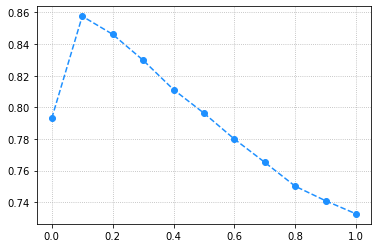

In [4]:
params = np.arange(0, 1.1, 0.1)
train_scores, test_scores = ms.validation_curve(model,
                                                train_x,
                                                train_y,
                                                'alpha',
                                                params,
                                                cv=10)
scores = test_scores.mean(axis=1)
# 验证可视化操作
plt.grid(linestyle=':')
plt.plot(params, scores, 'o-',
         color="dodgerblue",
         label='random_state VC',
         linestyle='--')
plt.legend


## 学习曲线，选取每次喂入的最优训练集大小

<function matplotlib.pyplot.legend(*args, **kwargs)>

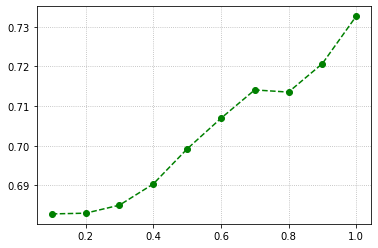

In [5]:
params = np.arange(0.1, 1.1, 0.1)
_, train_scores, test_scores = ms.learning_curve(model,
                                                 train_x,
                                                 train_y,
                                                 train_sizes=params,
                                                 cv=10)
scores = test_scores.mean(axis=1)
# 验证可视化操作
plt.grid(linestyle=':')
plt.plot(params, scores, 'o-', color="green", label='learning curve VC',
         linestyle='--')
plt.legend

In [6]:
scores = ms.cross_val_score(model, tfidf, data["label"],
                            cv=10, scoring='f1_weighted')
print(scores.mean())

# 训练模型
model.fit(train_x, train_y)

# 测试模型，评估模型
pred_test_y = model.predict(test_x)
print(sm.classification_report(test_y, pred_test_y))
print("混淆矩阵")
print(sm.confusion_matrix(test_y, pred_test_y))

0.7052972980480733
              precision    recall  f1-score   support

           0       0.98      0.18      0.30       717
           1       0.73      1.00      0.84      1613

    accuracy                           0.75      2330
   macro avg       0.86      0.59      0.57      2330
weighted avg       0.81      0.75      0.68      2330

混淆矩阵
[[ 127  590]
 [   2 1611]]


In [7]:
test_data = ["总体来说房间非常干净，卫浴设置也相当不错，交通也比较便利",
             "酒店交通方便，环境也不错，正好是我们办公地点的旁边，感觉性价比也还可以",
             "设施还可以，服务人员态度也不错，交通还算便利",
             "酒店位于交通要道上，标志和明显很好找，晚上比较安静，早餐挺不错，服务也比较到位",
             "酒店服务态度极差，设施很差",
             "我住过的最不好的酒店，以后绝不会再住了",
             "说实在的，我很失望，我想这家酒店以后无论如何也不会再去了",
             "刚住进去，就闻到一股异味，感觉极不舒服。晚上蚊子比较多，地板上也比较脏，电视遥控器都是坏的。还这么高的价格",
             "交通不便利，环境也不怎么样，也没有早餐。但是价格便宜，性价比比价高，毕竟只有那点钱",
             "交通方便，环境也不错，房间非常干净，卫浴设置也相当不错。晚上蚊子比较多，地板上也比较脏。总之没有说的那么好", ]

test_data = pd.Series(test_data).apply(func)
# 把样本按照训练时的方式转换为tfidf矩阵，才可以继续预测
bow = cv.transform(test_data)
test_data = tt.transform(bow)
pred_test_y = model.predict(test_data)

# 输出置信概率
pred_prob_y = model.predict_proba(test_data)

print(pred_test_y)
probs = pred_prob_y.max(axis=1)

for b, c in zip(pred_test_y, probs):
    print(b, ':', c)

[1 1 1 1 0 0 0 1 1 1]
1 : 0.9851352428651704
1 : 0.9793404818126737
1 : 0.9821931625458118
1 : 0.9784662405497451
0 : 0.6123339420690898
0 : 0.7343340114112049
0 : 0.6114033541031018
1 : 0.5609077479877286
1 : 0.9487111075125522
1 : 0.9595905256787345
